<a href="https://colab.research.google.com/github/nepalprabin/deeplearning-tensorflow/blob/master/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
import urllib
import tensorflow as tf
from tensorflow.keras.datasets import mnist
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

24576/17858 [=========================================] - 0s 0us/step


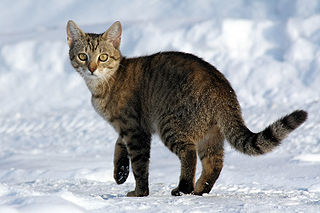

In [5]:
image_path = tf.keras.utils.get_file("cat.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")
PIL.Image.open(image_path)

In [0]:
#Read nad decode the image to tensor format
image_string = tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string, channels=3)

In [0]:
#Function to visualize and compare original image and augmented image
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original Image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('AUgmented Image')
  plt.imshow(augmented)

Augment a single image


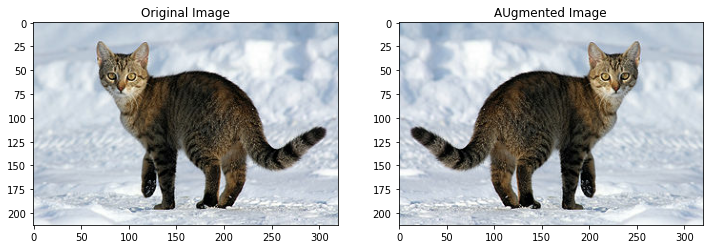

In [8]:
#Flipping the image
#Flip the image either vertically or horizontally
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

Grayscale the image

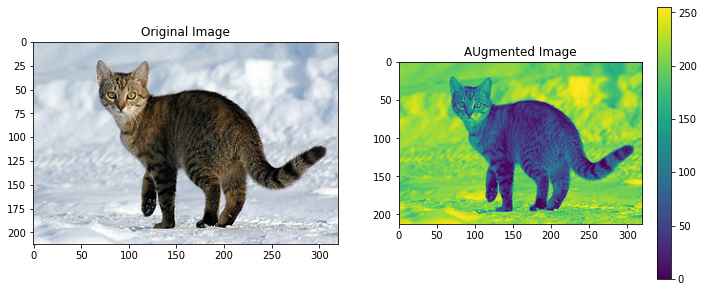

In [9]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

Saturate the image

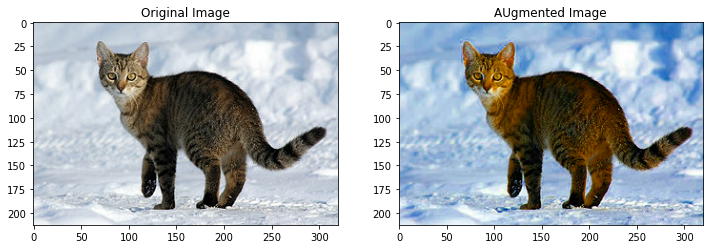

In [10]:
#Saturate the image by providing a saturation factor
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

Change image brightness

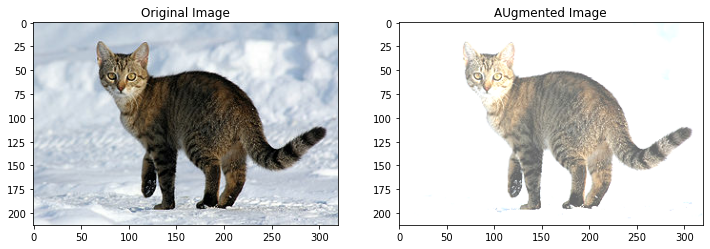

In [11]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

Rotate the image

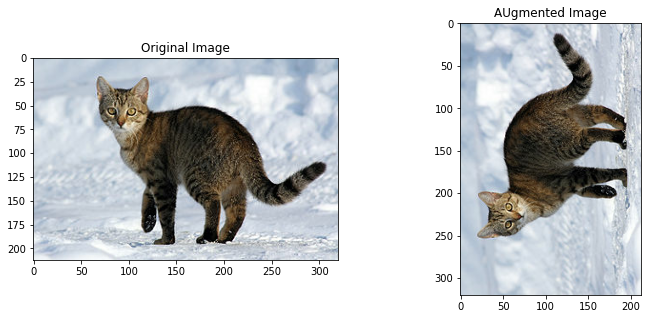

In [12]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

Center crop the image

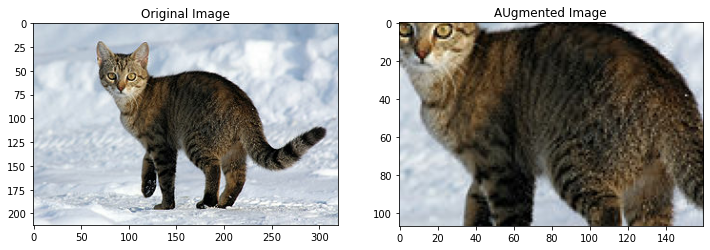

In [13]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

In [14]:
#Augment a dataset and train a model with it
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [0]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

  return image,label

In [0]:
BATCH_SIZE = 64
NUM_EXAMPLES = 2048

In [0]:
#Creating augmented dataset
augmented_train_batches = (
    train_dataset
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)

    #Augmentation
    .map(augment,num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
#Creating augmented dataset
non_augmented_train_batches = (
    train_dataset
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)

    #No augmentation
    .map(convert,num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
#Validation dataset
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [0]:
#Create and compile model
def make_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
      tf.keras.layers.Dense(4096, activation='relu'),
      tf.keras.layers.Dense(4096, activation='relu'),
      tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [29]:
#Training the model without augmentation
model_without_aug = make_model()
no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 2s 68ms/step - loss: 0.7439 - accuracy: 0.7729 - val_loss: 0.4387 - val_accuracy: 0.8612
Epoch 2/50
32/32 [==============================] - 2s 62ms/step - loss: 0.1621 - accuracy: 0.9468 - val_loss: 0.3108 - val_accuracy: 0.9095
Epoch 3/50
32/32 [==============================] - 2s 63ms/step - loss: 0.0600 - accuracy: 0.9839 - val_loss: 0.2884 - val_accuracy: 0.9235
Epoch 4/50
32/32 [==============================] - 2s 62ms/step - loss: 0.0510 - accuracy: 0.9858 - val_loss: 0.3719 - val_accuracy: 0.9047
Epoch 5/50
32/32 [==============================] - 2s 61ms/step - loss: 0.0453 - accuracy: 0.9839 - val_loss: 0.3748 - val_accuracy: 0.9196
Epoch 6/50
32/32 [==============================] - 2s 63ms/step - loss: 0.0279 - accuracy: 0.9868 - val_loss: 0.3991 - val_accuracy: 0.9106
Epoch 7/50
32/32 [==============================] - 2s 63ms/step - loss: 0.0451 - accuracy: 0.9844 - val_loss: 0.4953 - val_accuracy: 0.9001
Epoch 8/50
32

In [30]:
#With augmentation
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)

Epoch 1/50
32/32 [==============================] - 2s 67ms/step - loss: 2.5433 - accuracy: 0.2471 - val_loss: 1.4094 - val_accuracy: 0.4843
Epoch 2/50
32/32 [==============================] - 2s 66ms/step - loss: 1.4941 - accuracy: 0.4731 - val_loss: 0.7817 - val_accuracy: 0.7633
Epoch 3/50
32/32 [==============================] - 2s 66ms/step - loss: 1.1226 - accuracy: 0.6118 - val_loss: 0.6134 - val_accuracy: 0.8358
Epoch 4/50
32/32 [==============================] - 2s 65ms/step - loss: 0.8780 - accuracy: 0.7163 - val_loss: 0.4331 - val_accuracy: 0.8742
Epoch 5/50
32/32 [==============================] - 2s 66ms/step - loss: 0.6360 - accuracy: 0.7900 - val_loss: 0.3551 - val_accuracy: 0.8924
Epoch 6/50
32/32 [==============================] - 2s 63ms/step - loss: 0.6089 - accuracy: 0.7969 - val_loss: 0.3328 - val_accuracy: 0.9007
Epoch 7/50
32/32 [==============================] - 2s 64ms/step - loss: 0.5496 - accuracy: 0.8149 - val_loss: 0.3070 - val_accuracy: 0.9033
Epoch 8/50
32

(0.75, 1.0)

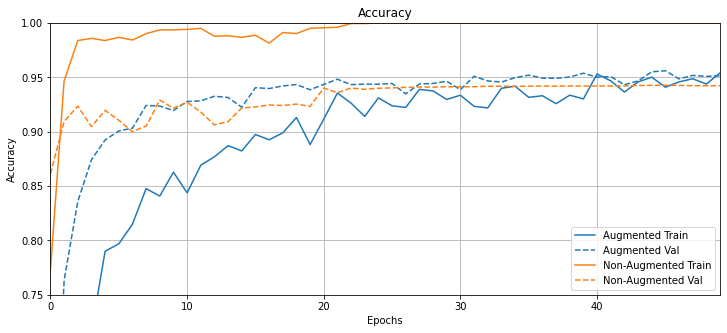

In [34]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])

(0.0, 1.0)

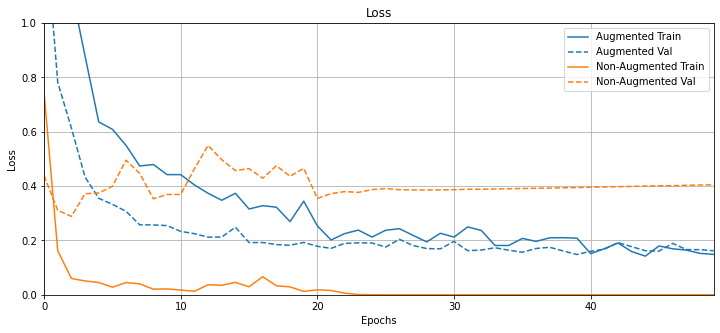

In [39]:
#Plotting loss
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "loss")
plt.title("Loss")
plt.ylim([0, 1])